In [1]:
import os

import torch 
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

import zipfile
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class args:
    epoch = 10
    batch_size = 64

* device를 설정해 놓으면 to.device를 용이하게 쓸 수 있음, gpu가 사용 가능한 상태라도 cpu로 설정해 놓으면 cpu만 사용 가능하기 때문

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"
# device = "cpu"

* Kaggle에서 Dogs vs . Cats Competition 데이터를 받아온 후 압축 해제

In [4]:
train_data_path = "/kaggle/input/dogs-vs-cats/train.zip"
test_data_path =  "/kaggle/input/dogs-vs-cats/test1.zip"
for path in [train_data_path, test_data_path]:
    with zipfile.ZipFile(path, "r") as zip:
        zip.extractall()

* 가용 메모리상 전체 데이터를 사용할 수 없어 파일 이름의 순서대로 정렬한 후 512개만 무작위로 추출

In [5]:
train_files = os.listdir("/kaggle/working/train")
cat_files = sorted([file for file in train_files if file.split(".")[0] == "cat"], key=lambda x: int(x.split(".")[1]))
dog_files = sorted([file for file in train_files if file.split(".")[0] == "dog"], key=lambda x: int(x.split(".")[1]))

In [6]:
cat_random_sample = np.random.choice(cat_files, 512)
dog_random_sample = np.random.choice(dog_files, 512)

* Dogs vs. Cats 파일의 이미지 크기가 모두 달라, 256 * 256 크기로 Resize

In [7]:
def img_resize(files,path):
    img_to_numpy = []
    for file in tqdm(files):
        file_img = Image.open(f"{path}/{file}")
        file_img = file_img.resize((256,256))
        img_to_numpy.append(np.array(file_img))
    return np.array(img_to_numpy)


In [8]:
numpy_cat = img_resize(cat_random_sample, "/kaggle/working/train")
# cat_label = np.array([0]*len(numpy_cat))
numpy_dog = img_resize(dog_random_sample, "/kaggle/working/train")
# dog_label = np.array([1]*len(numpy_cat))

100%|██████████| 512/512 [00:02<00:00, 223.79it/s]


* 일반적인 image shape은 [height, width, channel] 이지만 torch에서 사용하는 image shape은 [hannel, height, width]
* torchvision 패키지의 transforms.ToTensor를 사용하여 torch에 맞는 image shape으로 바꿔주는 것

In [9]:
torch_cat = torch.stack([transforms.ToTensor()(cat_img) for cat_img in numpy_cat])
# torch_cat_label = torch.IntTensor(cat_label)
torch_dog = torch.stack([transforms.ToTensor()(dog_img) for dog_img in numpy_dog])
# torch_dog_label = torch.IntTensor(dog_label)

In [ ]:
torch_cnd = torch.concat([torch_cat, torch_dog])
X_train, X_test = train_test_split(torch_cnd, test_size=0.2)

In [ ]:
batch_train_x = DataLoader(X_train, batch_size=16)
# batch_train_y = DataLoader(y_train, batch_size=8)
batch_valid_x = DataLoader(X_test, batch_size=16)
# batch_valid_y = DataLoader(y_test, batch_size=8)

* 간단한 구조의 Convolution Layer로 Encoder, Decoder 구성
* Conv2d Layer를 2번 중첩해서 Latent Vector로 이미지를 변환하고, Latent Vector에서 ConvTranspose2d를 사용해서 다시 이미지 크기로 변환한다.

In [ ]:
class AutoEncoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        
        #ENC
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(2,2)
        
                #DEC
        self.dec_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0)
        self.dec_conv2 = nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2, padding=0)
        
        #
        self.sigmoid = nn.Sigmoid()
    def encoder(self, x):
        x = self.enc_conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool2d(x)
        x = self.enc_conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        return x
    
    def decoder(self, x):
        x = self.dec_conv1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.dec_conv2(x)
        x = self.dropout(x)
        return x
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

* GPU 사용을 위한 .to(device) 다만 to.cuda() 대신 device를 쓰면 GPU 사용이 가능한 상황에서도 CPU 연산으로 사용할 수 있다.

In [ ]:
model = AutoEncoder_conv().to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
def train_process(model, train_data, valid_data):
    model = model.to(device)
    for epoch in range(1, 100):
        train_loss = 0
        for t_batch in train_data:
            optimizer.zero_grad()
            train_x, target_x = t_batch.to(device), t_batch.to(device)
            predicted_target = model(train_x)
            t_loss = criterion(predicted_target, target_x)
            train_loss += t_loss
            t_loss.backward()
            optimizer.step()

        with torch.no_grad():
            valid_loss = 0
            for v_batch in valid_data:
                valid_x, check_x = v_batch.to(device), v_batch.to(device)
                predicted_valid = model(valid_x)
                v_loss = criterion(predicted_valid, valid_x)
                valid_loss += v_loss
                
        if epoch % 10 == 0:
            print("Epoch:", epoch, "|", "Train Loss:", round(train_loss.item()/len(batch_train_x), 2), "Valid Loss:", round(valid_loss.item()/len(batch_valid_x), 2))
        

In [ ]:
train_process(model, batch_train_x, batch_valid_x)

Epoch: 10 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 20 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 30 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 40 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 50 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 60 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 70 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 80 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 90 | Train Loss: 0.02 Valid Loss: 0.02


* 성능평가

In [ ]:
train_files = os.listdir("/kaggle/working/test1")
test_files = sorted([file for file in train_files], key=lambda x: int(x.split(".")[0]))

In [ ]:
test_files_numpy = img_resize(test_files, "/kaggle/working/test1")

100%|██████████| 12500/12500 [00:50<00:00, 247.36it/s]


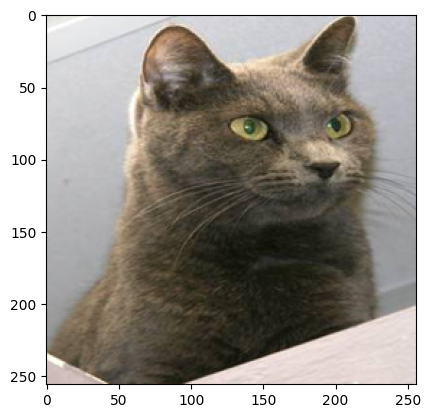

In [ ]:
plt.imshow(test_files_numpy[10])

In [ ]:
def inference_img(model, image):
    with torch.no_grad():
        image = transforms.ToTensor()(image)
        inf_img = model(image.to(device))
    return inf_img

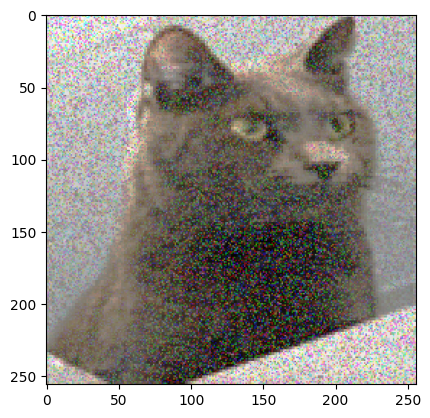

In [ ]:
image_recover = inference_img(model, test_files_numpy[10])
plt.imshow(image_recover.permute(1, 2, 0).cpu().numpy())

* Conv2d layer에 채널 수 늘려서 학습

In [ ]:
class AutoEncoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        
        #ENC
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(2,2)
        
                #DEC
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)
        self.dec_conv2 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2, padding=0)
        
        #
        self.sigmoid = nn.Sigmoid()
    def encoder(self, x):
        x = self.enc_conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool2d(x)
        x = self.enc_conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        return x
    
    def decoder(self, x):
        x = self.dec_conv1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.dec_conv2(x)
        x = self.dropout(x)
        return x
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

In [ ]:
model = AutoEncoder_conv().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
train_process(200, model, batch_train_x, batch_valid_x)

Epoch: 10 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 20 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 30 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 40 | Train Loss: 0.02 Valid Loss: 0.02
Epoch: 50 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 60 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 70 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 80 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 90 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 100 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 110 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 120 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 130 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 140 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 150 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 160 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 170 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 180 | Train Loss: 0.02 Valid Loss: 0.01
Epoch: 190 | Train Loss: 0.02 Valid Loss: 0.01


* 채널수를 늘려서 학습시킨다고 결과물은 큰 차이가 없다

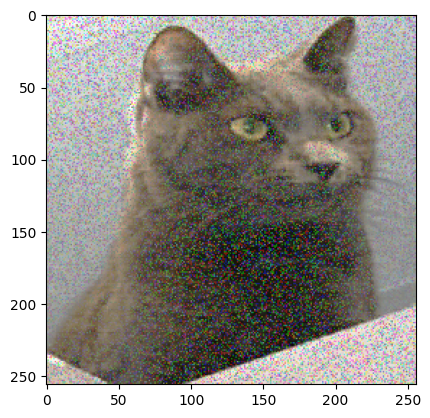

In [ ]:
image_recover = inference_img(model, test_files_numpy[10])
plt.imshow(image_recover.permute(1, 2, 0).cpu().numpy())